# Batch Crysallization Simulations
This is a case study of batch crystallization of certain sugar prodcuts. This template will be used to simulate many such systems that can generate data for ML model training or testing. 

It also provides a general understannding of the model equations, and how they are solved, along with the relevant code and results. 

## Generalized Crystallization kinetics 

Crystallization of a solute in a solvent will have a certain growth and nucleation kinetics, which will dictate the temporal evolution crystal size distribution (CSD). Generally, the empirical growth rate dervied from experiments is given as follows :

$$ G~(m/s) = k_g(\sigma)^b$$
where $k_g$ is the growth rate constant, $b$ is a constant, and $\sigma$ is relative supersaturation, which is defined as 
$$\sigma = \frac{c(t)-c_{sat}}{c_{sat}}$$
where $c(t)$ is the concentration of the crystallizing solute, and $c_{sat}$ is the soubility of the solute in the solvent. 
Similarly, the empirical nucleation rate is given as: 
$$ B~(\#/m^3 s) = k_n(\sigma)^a$$
where $k_n$ is the growth rate constant, and $a$ is a constant. 

## Population balance equation (PBE)

Given the abovementioned simple crystallizaiton kinetics, the CSD can be obtained by solving the PBE, which is given as follows:
$$ \frac{\partial n}{\partial t} + \frac{\partial (Gn)}{\partial L} = 0$$
where $n (t,L)$ is the \# of crystals with size $L$ at time $t$; that is to say that $n(t,L)$ is a distribution function of the crystal size. 

The initial condition is defined as follows:

$$ n(t=0,L)  = n_o$$ 
where $n_o$ is a predefined initial CSD.

The boundary condition is as follows:
$$ n(t,L=0) = B^o/G$$
where $B^o$ is the nucleation rate (\#/$m^3$ s)

Also, the PBE needs to be accompanied by the concentration balance equation, which is given as:
$$ \frac{\partial c}{\partial t} + \frac{\partial W}{\partial t} =0$$
where $c$ is the solute concentration and $ W$ is the mass of crystals.

Along with the above equations, the various 'moments' of crystallization are important as well, and they are defined as follows:

$$ m_i =  \int_{0}^{\infty} n(t,L)L^i dL  $$
where $m_i$ is the moment $i$ of the CSD. Consequently, 

$\frac{dN}{dt} = B^o$, is the zeroth moment representing total \# crystals in the system<br>
$\frac{dL_{total}}{dt} = NG$, is the first moment representing the total length of the crystals <br>
$\frac{dA_{crystals}}{dt} = 2k_aLG$, is the second moment representing the total area of all the crystals<br>
$\frac{dW}{dt} = 2\rho_{crystals}\frac{k_v}{k_a}AG$, is the third moment representing the total mass of all the crystals<br>
where $k_v$ is the volume shape factor, and $k_a$ is the area shape factor, and $\rho_{crystals}$ is the crystal bulk density.

## Case Study: Dextrose seeding crystallization with heterogeneous nucleation

Dextrose monohydrate is very important for sugar syrup manufacturing, and is produced from crystallizaiton of dextrose equivalent (DE) slurry, which is made dfrom hydrolysis of various crop-based starch. The purity of the DE syrup, and various impurities (i.e., maltose, and higher sugars) affects dextrose crystallization kinetics as suggested in the literature (DOI: https://doi.org/10.1016/j.jcrysgro.2012.04.021). In this work, the authors demonstrated batch crystallization of dextrose with a predetermined linear cooling temperature profile, and initial seeding to speed up crystallization. Although the PBE and the methodology to generate the CSD is similar to CASE_1 (Lysozyme), the growth and nucleation kinetics for dextrose are different.

Specficially, the growth kinetics is as follows:

$$ G~(m/s) = 1.14 \times 10^{-3}exp\left(\frac{-29549}{RT}\right) S^{1.05}$$
where $R$ is the universal gas constant, and $T$ is the temperature in $K$. 

As mentioned before, this specific case of dextrose crystallization includes seeding of crystals, and the temperature curve and supersatruation is maintained in a certain fashion that there is very little homogenous nucleation (which is not modeled). However, due to the agitator, and the seed crystals, there is heterogenous crystallization, and is given as follows:

$$ B~(\#/kg_{solution}s) = 4.50 \times 10^{4}M_T^{0.49}(S)^{1.41}$$

Also, the solubility of dextrose-water systems is not majorly affected by impurities, and is given by the following equation: 

$$  c_{sat} (kg_{dextrose}/kg_{solution}) = 0.804T + 29.94;~~T \in [30,50]~^{\circ}C$$ 


In [1]:
#Clear all variables and setup the workspace
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

import numpy as np
from IPython import get_ipython
from matplotlib import pyplot as plt

#Import local customizable functions
import system_fuctions, differential_function
import crystallization_kinetics as kinetics

plt.close('all'); #close all existing plots
plt.rcParams['font.size'] = '16'

from matplotlib.pyplot import figure
import pandas as pd

/var/folders/6r/76d59mjs0c1fb_2cps3rjpch0000gn/T/ipykernel_80218/280265842.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/6r/76d59mjs0c1fb_2cps3rjpch0000gn/T/ipykernel_80218/280265842.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


## Model Initialization

In [2]:
## Model Initialization [Basis of 1 kg_solution]

global R, rho_solvent, size_factor, time_intervals, rho_crystal, volume_shape_factor, area_shape_factor
global init_solub, initial_y, initial_boundaries, initial_F

R  = 8.314 # Universal gas constant
volume_shape_factor = np.pi/6; #Shape factor for spherical crystals
size_factor = 10**-6 # Converting the um into cm
rho_crystal = 1540 #kg/m^3 #Crystal density for Dextrose Monohydrate

#Decide the size range of the CSD based on prior/literature
minsize = 1 # um
maxsize = 1000 # um
intervals = maxsize # This is the # intervals to bin the crystals by their size 


#Solving time
time_to_solve = 3600*24 # in seconds # This is the crystallization time
time_intervals = 5000 # This is the number of steps in the ODE solution

### Dextrose Seeding
In this case, dextrose crystals of size 100 to 250 $\mu$ m are seeded in the batch crystallizer, and has a seed mass of 12.5%. Thus, if the basis of crystallization is 1 kg of solution, 0.125 kg should be the initial weight of crystals. 
For model initialization, set the mean size and distirbution of crystals in the 100 to 250 $\mu$ m range, and use the third moment to adjust the number of crystals to given an initial seed weight of 0.125 kg.

In [3]:

##Initial CSD [This information comes from the seed crystals]
init_crystals = 5*10**8;# (#/m^3) # Need to define some small value of # crystals at t = 0; If you are seeding then this value will change accordingly 
#Init_crystals can also be tuned using the total initial weight of crystals, and can also be changed to simulate seeding

initial_mean_size = 115# um 
initial_sigma_size = 60# um
initial_y = np.linspace(minsize*size_factor,maxsize*size_factor,num = intervals); 
initial_boundaries = np.linspace(minsize,maxsize,intervals+1)*size_factor
initial_F  =system_fuctions.normal_dist(initial_y/size_factor/maxsize,initial_mean_size/maxsize,initial_sigma_size/maxsize)

# Optimize number of initial crystals to match the 12.5% (w/w) seed
from scipy.optimize import minimize_scalar

# objective function
def objective(init_crystals):
    temp_F = initial_F/ sum(initial_F)*init_crystals
    initial_F[initial_F<0] = 0 # Cannot have negative sized crystals
    temp_weight = system_fuctions.moments(temp_F,3,initial_boundaries,initial_y)*volume_shape_factor*rho_crystal
    return (temp_weight - 0.125)**2

# minimize the function
result = minimize_scalar(objective, method='brent')
# summarize the result
opt_x, opt_y = result['x'], result['fun']
print('Number of initial seed crystals: %.0f' % round(opt_x))
print('Initial seed mass: %.3f' % (opt_y + 0.125))
print('Total Evaluations n: %d' % result['nfev'])

initial_F = initial_F/ sum(initial_F)*round(opt_x)
initial_F[initial_F<0] = 0 #cannot have negative sized crystals

#Initial Concentration
init_solution = 0.875 # Initial weight of the solution is 1-0.125 (seed crystals)
init_concentration = 0.67*init_solution #kg_dextrose/kg_solution

#Generating array for the initial state of the system
X0 = np.append(initial_F,init_concentration)

Number of initial seed crystals: 54552272879458
Initial seed mass: 0.125
Total Evaluations n: 20


## Crystallization Kinetics
Note: 
1. If this section is modified, copy the exact changes to the crystallization_kinetics.py file for the solution to take effect.
2. Moreover, this section is kept in the Jupyter Notebook for easy understanding of the underlying kinetics and functions

In [4]:
rho_crystal = 1540  #Density for Lysozyme crystals
volume_shape_factor = np.pi/6 #For tetragonal crystals

# Here S = C/C_sat; This is the saturation ratio


def growth_rate(S,T,y): # UNITS: in m/s    
    G = (S>1)*1.14*10**-3*np.exp(-29549/8.314/T)*(S-1)**1.05*np.ones(len(y));
    return G

# Heterogenous nucleation rate for dextrose
def nucleation_rate(conc,S,T,F,initial_boundaries,initial_y): # UNITS: #/s per kg_solution
    # T can be a np array
    M_T = system_fuctions.moments(F,3,initial_boundaries,initial_y)*volume_shape_factor*rho_crystal
    B= (S>1)*4.50*10**4*M_T**0.49*(S-1)**1.41
    
    
    return B
     
# Modify solubulity based on the system    
def solubility(T):
    # T can be a np array 
    global rhoc
    T = T- 273 # converting to Celsius
    c_sat = (0.804*T+29.94)*0.01  #UNITS: c_sat is in kg_dextrose/kg_solution
    return c_sat


# Linear temperature profile
def Tprofile(t): # Output UNITS: Kelvin
    T = 42-0.375*(t/3600)   # Linear profile with temperature decreasing from 42C to 33 C in 24 h 
    # T   = 42-0.375*(t/3600)+ 2*np.sin(t/3600) #Sinusoidal Temperature Profile
    T =T+273
    return T

## Generate Solution

In [5]:
# %% Finite difference method for the system of ODEs
# Here, the Initial Value Problem (IVP) solver from SCIPY is utilized

from scipy.integrate import odeint, solve_ivp
t_span = (0.0, time_to_solve) #The time-window in which the solution is generated
result_solve_ivp = solve_ivp(differential_function.differential_function, t_span, X0, method='RK45', args =(initial_boundaries,initial_y))

final_times = result_solve_ivp.t; #The output time for the solution
X_out = result_solve_ivp.y; # Solver output
conc_profiles = X_out[-1,:]; # Temporal evolution of concentration
final_dists = X_out[0:-1,:] # Temporal CSD 

## Result Plotting

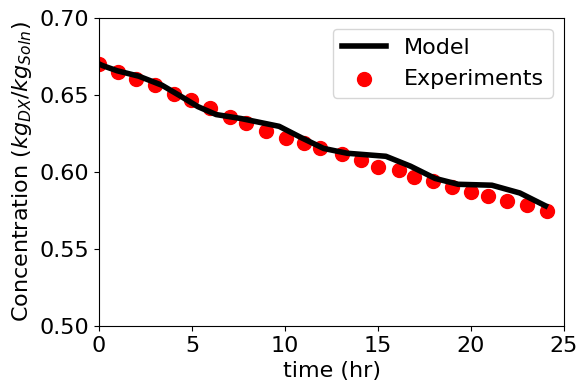

<Figure size 600x400 with 0 Axes>

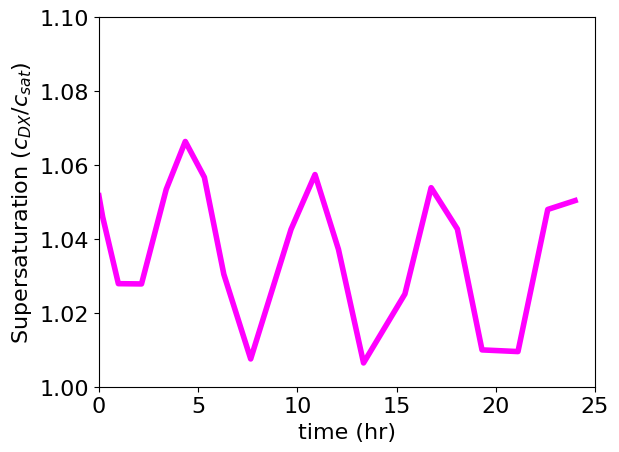

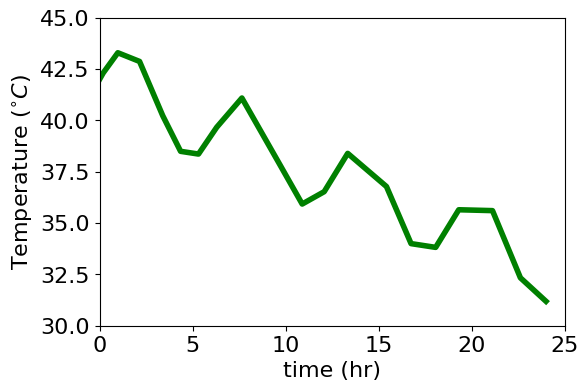

In [6]:
# Concentration Plotting
figure(figsize=(6,4), dpi=100)
df_expt = pd.read_excel('expt_data.xlsx',sheet_name='conc_dextrose')
plt.plot(final_times/3600,conc_profiles/0.875, linewidth=4,color = 'black',label='Model')
plt.scatter(df_expt['time (h)'],df_expt.iloc[:,1],100,color='red', label ='Experiments')
plt.xlabel('time (hr)')
plt.ylabel('Concentration ($kg_{DX}/kg_{Soln}$)')
plt.ylim(0.5,0.7)
plt.xlim(0,25)
plt.legend()
plt.show()


# Plotting Supersaturation
figure(figsize=(6,4), dpi=100)
plt.figure()
plt.plot(final_times/3600,conc_profiles/0.875/kinetics.solubility(kinetics.Tprofile(final_times)), linewidth=4,color = 'magenta',label='Model')
plt.xlabel('time (hr)')
plt.ylabel('Supersaturation ($c_{DX}/c_{sat}$)')
plt.ylim(1,1.1)
plt.xlim(0,25)
plt.show()

#Plotting Cooling Curve
figure(figsize=(6,4), dpi=100)
plt.plot(final_times/3600,kinetics.Tprofile(final_times)-273, linewidth=4,color = 'green',label='Linear Profile')
plt.xlabel('time (hr)')
plt.ylabel('Temperature ($^{\circ}C$)')
plt.ylim(30,45)
plt.xlim(0,25)
plt.show()

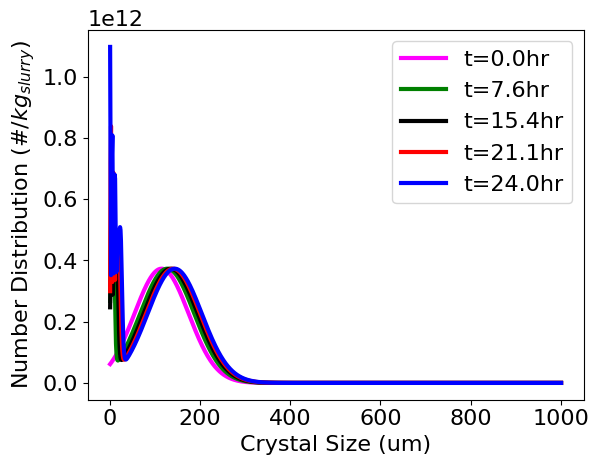

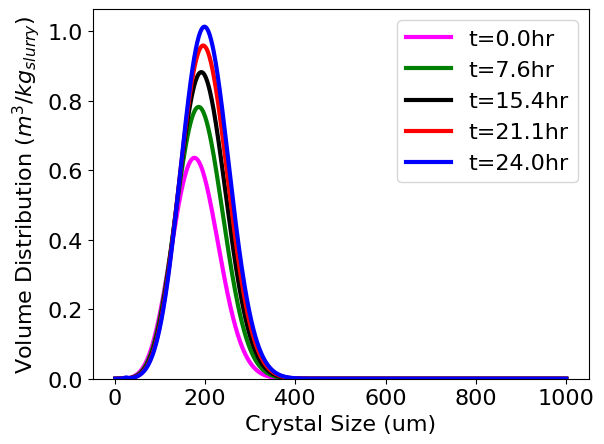

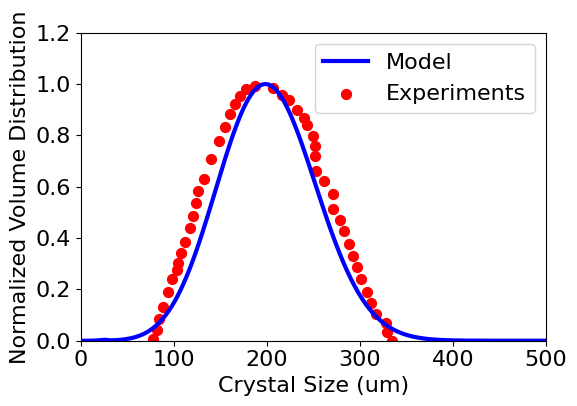

In [7]:
# %% Plotting CSD
color_list = ['magenta','green','black','red','blue']

plot_time_list = np.array([10,50,75,90,100])*len(final_times)*0.01;  #Percentage of total simulation time
plot_time_list = plot_time_list.round(0) ; #Rounding off the time indices to integers
plot_time_list = plot_time_list.astype(int) 

counter = 0
legend_entries = []
Fmat = np.zeros((len(plot_time_list),intervals))
FmatV = np.zeros((len(plot_time_list),intervals))


for j in plot_time_list:
    i = int(j-1)
    legend_entries.append('t=' + str(round(final_times[i]/3600,1)) +'hr')    
    Fmat[counter,:] = final_dists[:,i]; # Number of crystals per m^3 of solution
    FmatV[counter,:] = volume_shape_factor*final_dists[:,i]*initial_y**3 ; # Volume of crystals per kg of slurry
    counter = counter +1


# Number Distribution 
# figure(figsize=(6,4), dpi=300)
plt.figure(dpi = 100)
for i in range(0,counter):
    plt.plot(initial_y/size_factor,Fmat[i,:], linewidth=3,color = color_list[i]); 

plt.legend(legend_entries)  
plt.xlabel('Crystal Size (um)')
plt.ylabel('Number Distribution ($\#/ kg_{slurry}$)')
# plt.ylim(0,5*10**7)
# plt.xlim(0,300)
plt.show()


# Volume Distribution 
plt.figure(dpi = 100) 
for i in range(0,counter):
    plt.plot(initial_y/size_factor,FmatV[i,:], linewidth=3,color = color_list[i]); 
   
   
    
plt.legend(legend_entries) 
plt.xlabel('Crystal Size (um)')
plt.ylabel('Volume Distribution ($m^3/kg_{slurry}$)')
plt.ylim(0,)
# plt.xlim(0,300)
plt.show()  


# Normalized Volume Distribution 
figure(figsize=(6,4), dpi=100)
df_expt = pd.read_excel('expt_data.xlsx',sheet_name= 'dextrose_CSD')

plt.plot(initial_y/size_factor,FmatV[-1,:]/max(FmatV[-1,:]), linewidth=3,color = 'blue',label='Model'); 
plt.scatter(df_expt.iloc[:,0],df_expt.iloc[:,2],50, color='red',label ="Experiments")

plt.legend()
plt.xlabel('Crystal Size (um)')
plt.ylabel('Normalized Volume Distribution')
plt.ylim(0,1.2)
plt.xlim(0,500)
plt.show()  



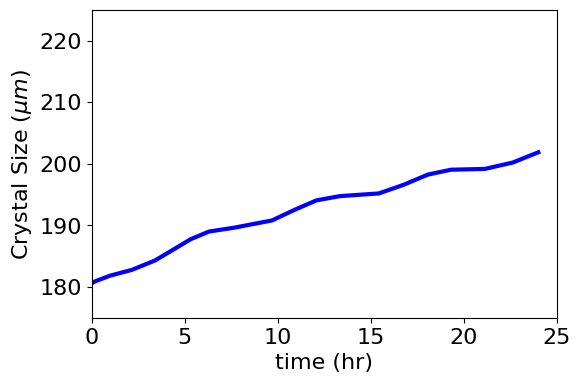

In [8]:
# %% Crystal Size Evolution

downsized_dists=  final_dists; #This can be used to down size a large output array # By default, no downsizing is performed
mean_dia = system_fuctions.moments_array(downsized_dists[:,:],1,initial_boundaries,initial_y)/(system_fuctions.moments_array(downsized_dists[:,:],0,initial_boundaries,initial_y));
std_dev = system_fuctions.moments_array(downsized_dists[:,:],2,initial_boundaries,initial_y)/(system_fuctions.moments_array(downsized_dists[:,:],0,initial_boundaries,initial_y)); - mean_dia**2;

# Calculate the Sauter Mean Diameter (SMD)
SMD = system_fuctions.moments_array(downsized_dists[:,:],4,initial_boundaries,initial_y)/(system_fuctions.moments_array(downsized_dists[:,:],3,initial_boundaries,initial_y));

y_min = (SMD - np.sqrt(std_dev))/size_factor
y_max = (SMD + np.sqrt(std_dev))/size_factor

figure(figsize=(6,4), dpi=100)
plt.plot(final_times/3600,SMD/size_factor,'blue',linewidth=3, label = 'Model SMD')
plt.xlabel('time (hr)')
plt.ylabel('Crystal Size ($\mu m$)')
plt.ylim(175,225)
plt.xlim(0,25)
plt.show()  